# Sketching scale sigma parameter selection

## Introduction

The sketching scale is a crucial hyper-parameter for compressive clustering. Unfortunately, it is not easy to know in advance what it is. Some strategies have been proposed to try to tune and this notebook is about presenting them. We start by setting up the experiment.

In [1]:
# General imports
import numpy as np
import torch
import matplotlib.pyplot as plt
from loguru import logger
import sys
import time
from IPython.display import Markdown as md


# Logger made less verbose
logger.remove()
logger.add(sys.stderr, level="WARNING")

# Fix the random seed for reproducibility
seed = 5

# Choose torch device
device = torch.device('cpu') # on GPU, use 'cuda:0' in place of 'cpu'

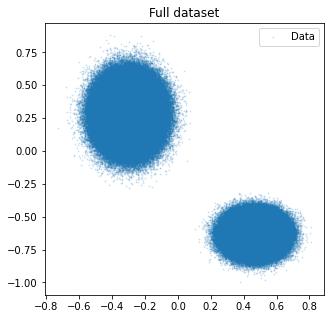

In [2]:
from pycle.utils.datasets import generatedataset_GMM
from pycle.utils.vizualization import simple_plot_clustering

d = 2     # Dimension
K = 2     # Number of Gaussians
n = 2000000 # Number of samples we want to generate we use a huge number to illustrate the benefit of the method when the sketching phase is long
# We use the generatedataset_GMM method from pycle (we ask that the entries are <= 1, and imbalanced clusters)
X = generatedataset_GMM(d, K, n, normalize='l_inf-unit-ball', imbalance=1/3, seed=seed).to(device)

# Bounds on the dataset, necessary for compressive k-means
bounds = torch.cat((-torch.ones(1, d),torch.ones(1, d)), 0) # We assumed the data is normalized between -1 and 1

# Visualize the dataset
simple_plot_clustering(X, title="Full dataset")


m = 5*K*d # number of frequencies
array_repeats = np.arange(5) # number of replicates
lst_sigmas = np.logspace(-3, 1, 10) # the sigma that we could want to brute force.

In [3]:
from pycle.sketching.frequency_sampling import drawFrequencies
from pycle.sketching.feature_maps.MatrixFeatureMap import MatrixFeatureMap
from pycle.sketching import computeSketch
from pycle.compressive_learning.CLOMP_CKM import CLOMP_CKM
from pycle.utils.metrics import SSE

## Naive brute forcing

The most straightforward method to tune sigma is simply to use many sigmas in a reasonnable range, solve the problem for each of them and just pick the best solution. One could also imagine doing the same thing but with a simpler instance of the problem (less data, less optimization iteration), pick the best sigma in that setting and just re-do the experiment. This is not what we show here but the idea is similar. 

This method work well but it is obviously very long and ressource consuming.

In [4]:
def sketch_and_decode(sigma):
    """
    Sketch the dataset and then decode using CLOMP. Return the obtained SSE performance.
    
    Parameters
    ----------
    sigma
        The scale of the sketching operator. 
    """
    # assume isotropic and same variance Gaussians
    Sigma = sigma * torch.eye(d).to(device)
    Omega = drawFrequencies("FoldedGaussian", d, m, Sigma).to(device)

    Phi = MatrixFeatureMap("ComplexExponential", Omega, device=device)

    z = computeSketch(X, Phi, verbose=False)
    ckm_solver = CLOMP_CKM(Phi, size_mixture_K=K, bounds=bounds, sketch_z=z)

    ckm_solver.fit_once()

    (centroids, weights) = ckm_solver.current_solution
    return SSE(X,centroids)
    

In [5]:
# this is the brute force / grid search loop
start = time.time()
array_sse = np.empty((len(array_repeats), len(lst_sigmas)))
for i_repeat, repeat in enumerate(array_repeats):
    print(f"repeat: {i_repeat}")
    for i_sigma, sigma in enumerate(lst_sigmas):
        array_sse[i_repeat, i_sigma] = sketch_and_decode(sigma)
lst_sse = list(np.mean(array_sse, axis=0))
stop = time.time()
time_naive = stop-start
print(f'Runtime: {time_naive:.2f}s')

repeat: 0


/home/luc/anaconda3/envs/dict/lib/python3.9/site-packages/torch/autograd/__init__.py:147: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at  ../aten/src/ATen/native/Copy.cpp:240.)
  Variable._execution_engine.run_backward(


repeat: 1
repeat: 2
repeat: 3
repeat: 4
Runtime: 107.56s


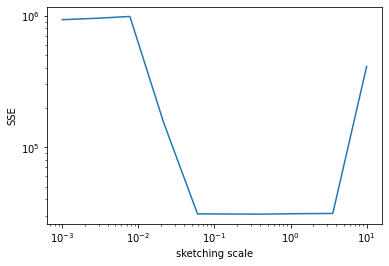

In [6]:
plt.xscale("log")
plt.yscale("log")
plt.xlabel("sketching scale")
plt.ylabel("SSE")
plt.plot(lst_sigmas, lst_sse)

In [7]:
md(f"From this plot, we can see that the best value for sigma is $\sigma = {lst_sigmas[np.argmin(lst_sse)]:.2f}$. However, this information was obtained in {time_naive:.2f} seconds.")

From this plot, we can see that the best value for sigma is $\sigma = 0.46$. However, this information was obtained in 107.56 seconds.

## Mutualized sketching

Finding the best sigma value took a lot of time not only because the CLOMP algorithm has to run for each sigma value but also because one different sketch was computed for each sigma value. There is nothing much we can do to alleviate the cost of CLOMP but in fact, the cost of computing all the sketches can be strongly reduced by mutualizing the bulk of the computation between the sketches. That is: the matrix vector products between the frequencies matrix and each observation.

In [8]:
from pycle.sketching import pick_sketch_by_indice_in_aggregated_sketch

In [9]:
def multi_sigma_sketch(arr_sigma):
    """
    
    Notes
    -----
        - This uses variables from the global scope. I think it is easier for the readability of the function and function calls.
    
    Parameters
    ----------
    arr_sigma
        The array of possible sigma values. For each sigma in this array, a whole sketch will be computed
        
    Returns
    -------
        - The mutualized sketch built from the concatenation of all the sketches corresponding to all the sigmas
        - The matrix of directions
        - The array of amplitudes, one for each direction
    """
    arr_sigma_inv_sqrt, directions, R = drawFrequencies("FoldedGaussian", d, m, arr_sigma, keep_splitted=True)
    print(R.shape)
    print(sigma.shape)
    Phi = MatrixFeatureMap("ComplexExponential", (arr_sigma_inv_sqrt, directions, R), device=device)

    z = computeSketch(X, Phi, verbose=False)
    return z, arr_sigma_inv_sqrt, directions, R

In [10]:
def decode_for_one_sigma(z, index_sigma, array_sigmas, directions, R):
    """
    Parameters
    ----------
    z
        The mutualized sketch built from the concatenation of all the sketches corresponding to all the sigmas
    index_sigma
        The index of the sigma in the array of sigmas
    array_sigmas
        The array of all the sigmas
    directions
        The matrix of all the unit norm directions
    R
        The array of amplitudes corresponding to each direction
    """
    loaded_sketch = pick_sketch_by_indice_in_aggregated_sketch(z, index_sigma, m)
    
    sigma_inv_sqrt = array_sigmas[index_sigma]
    Phi = MatrixFeatureMap("ComplexExponential", (sigma_inv_sqrt, directions, R), device=device)
    
    ckm_solver = CLOMP_CKM(Phi, size_mixture_K=K, bounds=bounds, sketch_z=loaded_sketch)
    ckm_solver.fit_once()
    (centroids, weights) = ckm_solver.current_solution
    return SSE(X,centroids)
    

In [11]:

start = time.time()

array_sse = np.empty((len(array_repeats), len(lst_sigmas)))

mutualized_sketch, arr_sigma_inv_sqrt, directions, R = multi_sigma_sketch(lst_sigmas)
print(mutualized_sketch.shape)
for i_repeat, repeat in enumerate(array_repeats):
    print(f"repeat: {i_repeat}")
    for i_sigma, sigma in enumerate(arr_sigma_inv_sqrt):
        array_sse[i_repeat, i_sigma] = decode_for_one_sigma(mutualized_sketch, i_sigma, arr_sigma_inv_sqrt, directions, R)
lst_sse = list(np.mean(array_sse, axis=0))

stop = time.time()
time_mutualized = stop-start
print(f'Runtime: {time_mutualized:.2f}s')

torch.Size([20])
()
torch.Size([200])
repeat: 0
repeat: 1
repeat: 2
repeat: 3
repeat: 4
Runtime: 25.09s


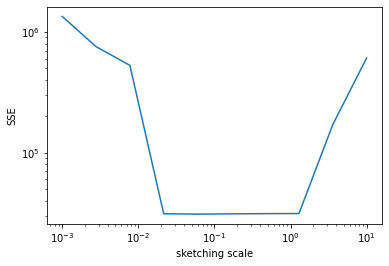

In [12]:
plt.xscale("log")
plt.yscale("log")
plt.xlabel("sketching scale")
plt.ylabel("SSE")
plt.plot(lst_sigmas, lst_sse)

In [13]:
md(f"From this plot, we can see that the best value for sigma is again $\sigma = {lst_sigmas[np.argmin(lst_sse)]:.2f}$. But this time, the information was obtained in only {time_mutualized:.2f} seconds, that is x{time_naive/time_mutualized:.1f} faster than naive sketching.")

From this plot, we can see that the best value for sigma is again $\sigma = 0.06$. But this time, the information was obtained in only 25.09 seconds, that is x4.3 faster than naive sketching.

Note that in the mutualized sketching case, the same set of directions is used for all sketches in contrary of the case when another set of directions is picked for each sketch. This is not an issue because we can consider that any random sampling of directions spans the unit sphere. If one want to re-sample the amplitudes for each direction, 

## Estimating sigma at hand

An other possible strategy for choosing sigma is to try an estimation method proposed in the litterature.



In [14]:
from pycle.sketching.sigma_estimation import estimate_Sigma, estimate_Sigma_by_entropy, get_sketch_entropy, estimate_Sigma_by_var

### Keriven's method

It is an iterative method based on an heuristic on the distribution of the modulus of the coefficients in the sketch that should follow a truncated centered gaussian. To find the best sigma, we use small sketches (size m0) computed on a subset of the dataset (size n0) and try to fit a centered gaussian to the coefficients.

In [15]:
sigma_estimated = estimate_Sigma(X.numpy(), m0=m, n0=n//5, drawFreq_type="FG")
sse = sketch_and_decode(torch.tensor(sigma_estimated))
print(f"Sigma: {sigma_estimated[0][0]}; SSE: {sse}")

/home/luc/PycharmProjects/pycle/pycle/sketching/sigma_estimation.py:295: UserWarning: WARNING: overfitting regime detected for frequency sampling fitting
  warnings.warn("WARNING: overfitting regime detected for frequency sampling fitting")


Sigma: 0.007128849610626999; SSE: 1683717.8555670893


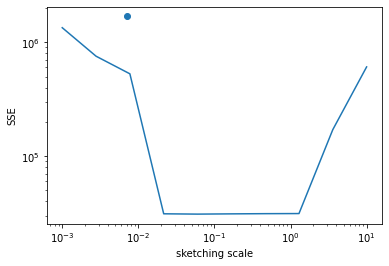

In [16]:
plt.xscale("log")
plt.yscale("log")
plt.xlabel("sketching scale")
plt.ylabel("SSE")
plt.plot(lst_sigmas, lst_sse)
plt.scatter([sigma_estimated[0][0]], [sse])

In this example, the Keriven's sigma estimation method fail to find the best sigma with the provided parameters.

### Entropy based method

An other approach is also based on a heuristic but this time the idea is rather that the sketch coefficients modulii should be well distributed between 0 and 1 so that their entropy is maximized.

In [17]:
sigma_estimated = estimate_Sigma_by_entropy(X, lst_sigmas, m0=m, n0=n//5, drawFreq_type="FG")
sse = sketch_and_decode(torch.tensor(sigma_estimated))
print(f"Sigma: {sigma_estimated}; SSE: {sse}")

Sigma: 0.007742636826811269; SSE: 32166.28175377719


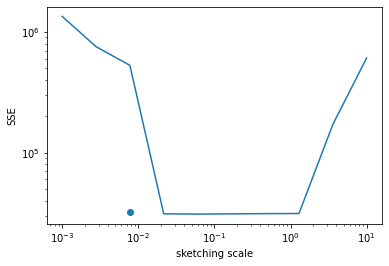

In [18]:
plt.xscale("log")
plt.yscale("log")
plt.xlabel("sketching scale")
plt.ylabel("SSE")
plt.plot(lst_sigmas, lst_sse)
plt.scatter([sigma_estimated], [sse])

In this example, entropy based sigma estimation also fails to estimate the right sigma.

### Variance based method

Last approach is simply to take the variance of the dataset.

In [19]:
sigma_estimated = estimate_Sigma_by_var(X)
sse = sketch_and_decode(torch.tensor(sigma_estimated))
print(f"Sigma: {sigma_estimated}; SSE: {sse}")

/tmp/ipykernel_642/2616951355.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  sse = sketch_and_decode(torch.tensor(sigma_estimated))


Sigma: 0.21225081392344924; SSE: 30897.873460420073


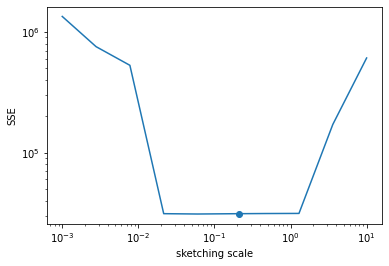

In [20]:
plt.xscale("log")
plt.yscale("log")
plt.xlabel("sketching scale")
plt.ylabel("SSE")
plt.plot(lst_sigmas, lst_sse)
plt.scatter([sigma_estimated], [sse])

In this example, variance based sigma estimation is the best sigma estimation method but it certainly is not always the case.

## Conclusion

As seen from the notebook, the most reliable way to find the best sigma is simply to grid search using mutualized sketching.